# **Poço Quadrado Infinito**

##**Resolvendo o Poço Quadrado Infinito**
### Calculando numericamente a evolução temporal da função de onda.
Aqui exploramos a função de onda à medida que ela evolui no tempo, para algum estado inicial genérico. Em vez de fazer cálculos matemáticos para computar as constantes $c_n$ , fazemos isso numericamente. Neste notebook, pressupõe-se que a solução da equação de Schrödinger seja conhecida ou já tenha sido calculada.

As soluções padrão do poço quadrado infinito, no domínio $0<x<a$, são dadas por:
$$
\left<x|\psi_n\right>=\psi_n(x) = \sqrt{\frac{2}{a}} \sin\left(\frac{n\pi x}{a}\right) \\
E_n = \frac{n^2 \pi^2 \hbar^2}{2ma^2}
$$

Para este problema, temos uma função de onda inicial escrita como $\Psi(x,t=0)$.
Agora nós queremos encontrar os coeficientes $c_n$, que é feito através de
$$
c_n = \left<\psi_n\right.\left|\Psi(t=0)\right> \\
= \int_0^a \psi_n(x) \Psi(x,t=0) dx
$$
Precisamos agora resolver esta integral numericamente, assim ela funcionará para qualquer função $\Psi(x,0)$.

Como realizamos a integração? Como de costume nesses tipos de problemas, existem várias maneiras de fazer isso, e a diferença será determinada pelo que está disponível para entrada, pela velocidade de execução e pela precisão do resultado que obtemos.

### **Metodo - SciPy**
Existe um ótimo método no pacote Scipy que faz a integração e cuida de todos os pequenos detalhes, como escolher um valor adequado para $N$. Podemos informar ao pacote a precisão desejada, de modo que podemos pedir que seja mais rápido ou mais preciso. O método faz parte do módulo **scipy.integrate** e é chamado quad(fun,low,hi,<options>), onde **fun** é a função (um método Python), e **low** e **hi** são os limites de integração, que podem ser **np.inf** para $\infty$.
Entre as opções, podemos definir **'limit=N'** para um máximo de **N** iterações, **'epsabs=1.E-4'** para obter uma precisão de $10^{-4}$. Consulte a documentação completa (https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.quad.html).

Fizemos uma simplificação escolhendo $m = 1$ e $\hbar = 1$, que essencialmente é uma escolha de unidades. Escolhemos a largura do poço como sendo $a$.

Então, para começar a programar, primeiro importamos os pacotes necessários:

In [ ]:
%matplotlib inline
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

Vamos programar nossa função de onda inicial.

Nós temos
$$
\Psi(x,0) = \left\{ \begin{matrix} A' x, \qquad &\mathrm{se\ } 0\le x \le a/2, \\ A'(a-x), \qquad &\mathrm{se\ } a/2\le x \le a \end{matrix}\right.
$$

Uma pequena questão com essa função, do ponto de vista do programa, é que ela apresenta uma descontinuidade em $x=a/2$. Também possui descontinuidades em $x=0$ e $x=a$, mas podemos concordar em nunca chamá-la com valores fora do intervalo $[0,a]$. A forma "normalizada" de implementar essa função seria:

In [ ]:
def f_slow(x,a):
    norm = np.sqrt(12./(a*a*a))
    if x < a/2:
        return(norm*x)
    else:
        return(norm*(a-x))

Realizamos um teste rápido para garantir que a saída faça sentido. Observe que se você escrever "12" em vez de "12.", obterá apenas zero como resultado. Precisamos ter certeza de usar ponto flutuante!

In [ ]:
print(f_slow(0,10.),f_slow(3,10),f_slow(5,10),f_slow(7,10),f_slow(10,10))

0.0 0.3286335345030997 0.5477225575051661 0.3286335345030997 0.0


O problema com nossa função é que não podemos chamá-la com um array, então:

"print f_slow([0,3.,5.,7.,10.],10.)"

irá falhar. A solução para isso é usar np.piecewise, que pode lidar com as condições em uma função em partes. Então obtemos:

In [ ]:
def f(x,a):
    norm = np.sqrt(12./(a*a*a))
    return(np.piecewise(x,[x<a/2.,x>=a/2.],
                        [lambda x: norm*x ,
                         lambda x: norm*(a-x)]))

In [ ]:
print(f(np.array([0,3,5,7,10],dtype=float),10))

[0.         0.32863353 0.54772256 0.32863353 0.        ]


Em seguida, definimos nossa função $\psi_n(x)$, que é bastante direta:

In [ ]:
def psi_n(x,n,a):
    return(np.sqrt(2./a)*np.sin(n*x*np.pi/a))

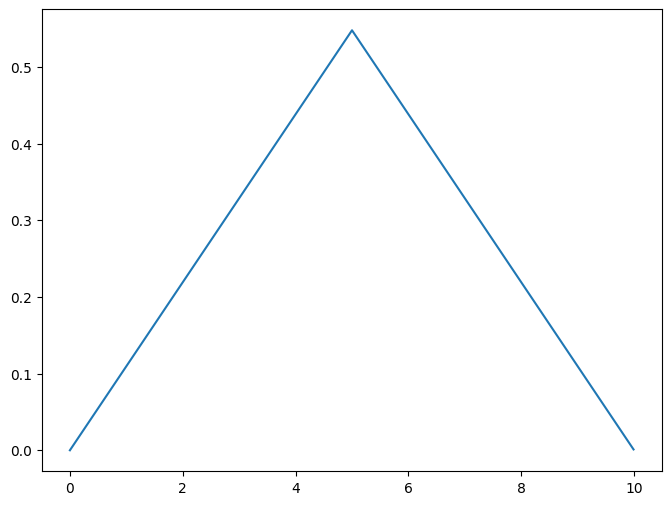

In [ ]:
fig0=plt.figure(figsize=(8,6))
x_r = np.arange(0,10,0.01)
p0=plt.plot(x_r,f(x_r,10))

Agora podemos calcular os $c_n$. Primeiro, escrevemos uma função básica chamada ccc que multiplica $\Psi(x,t=0)$ por $\psi_n(x)$ para um $n$ específico. Em seguida, encontramos o coeficiente $c_n$ integrando ccc de 0 até $a$.

In [ ]:
def int_fun(x,n,a):
    return(f(x,a)*psi_n(x,n,a))

def c(n,a):
    if n==0 or n%2==0:       # Sabendo que os valores de n pares são zero, adicionamos: "or n%2==0"
        return(0)
    return( spi.quad(int_fun,0,a,args=(n,a),limit=100)[0])

Como calcular essa integração a cada vez pode ser bastante lento, podemos pré-calcular os valores de $c_n$ e colocá-los em uma grande lista. Já que $c_{39}$ é bastante pequeno, podemos parar por aí.

In [ ]:
Nmax=40 # corte da série c_n. Higher = slower, mais preciso
a_l = 10. # largura do poço
a_step = 10./100. # Tamanho do passo em x, menor é mais preciso.
nl = np.array(range(Nmax))
cx = np.array([c(n,a_l) for n in nl])
print(cx[0],cx[1],cx[2],cx[3],cx[4])
print(np.sum(cx*cx),cx[Nmax-1])

0.0 0.9927408002342286 0.0 -0.11030453335935887 0.0
0.9999974367055641 -0.0006526895465042582


Neste ponto, podemos seguir o mesmo caminho que fizemos antes, quando tínhamos uma função simples para $c_n$. Observa-se que os gráficos abaixo são idênticos aos que encontramos anteriormente, portanto parece que esse método funciona.

Escrevemos uma função que codifica a função de onda dependente do tempo. Para isso, primeiro precisamos de uma função que retorne a energia do sistema. Simplificamos um pouco as coisas escolhendo $m=1$ e $\hbar=1$, o que essencialmente é uma escolha de unidades. Passamos o valor da largura do poço, $a$.

Nossa primeira versão dessa função é bastante direta, mas como chamamos essa função várias vezes ao fazer os gráficos, percebemos que, nesse caso, a lentidão dela se torna perceptível. Leva cerca de 2 minutos para fazer os gráficos. Uma versão mais rápida da função é escrita logo abaixo, que faz a mesma coisa, mas novamente usa as otimizações do Numpy. Essa versão faz os gráficos em cerca de 2 segundos no meu sistema.

In [ ]:
def E(n,a):
    return(n*n*np.pi*np.pi/(2.*a*a)) # We set m/hbar =1

def psi_f(x,t,a):
    norm =np.sqrt(2/a)
    out = 0
    n_r = np.array(range(Nmax))
    out = cx*norm*np.sin(x*n_r*np.pi/a)*np.exp(-1.j*E(n_r,a)*t)
    s = np.sum(out)
    return(s)

Agora, abaixo, fazemos os gráficos da parte real da função de onda para observar como ela evolui. Observe que, como se trata apenas da parte **real**, não esperamos que esses gráficos permaneçam normalizados. Abaixo disso, fazemos o mesmo para a parte imaginária da função de onda e, finalmente, para o módulo da função de onda. Nos últimos gráficos, a norma das curvas permanece igual a um.

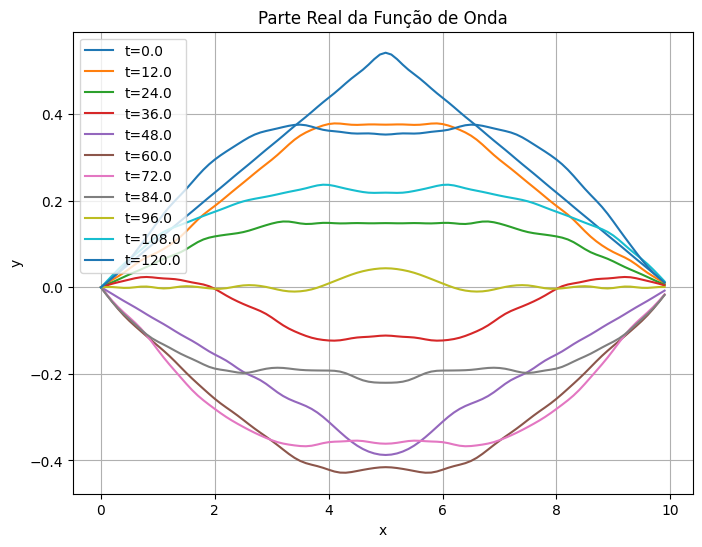

In [ ]:
fig1 = plt.figure(figsize=(8,6))
x_r = np.arange(0,a_l,.1)
plts=[]
for t in np.arange(0.,128.,12.):
    y_p = [np.real(psi_f(x,t,a_l)) for x in x_r]
    pp=plt.plot(x_r,y_p,label="t={}".format(t))
    plt.legend()
    plt.title("Parte Real da Função de Onda")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True,which='both')
    plts.append(pp)
#fig.show()

Legal, maspode ser bem mais interessante. Vamos transformar isso em uma animação.

E isso não é difícil de fazer em Python, mesmo em um notebook Python. A seguinte animação só funcionará se você carregar o notebook em seu próprio computador e executar as células.

Um detalhe a se pensar é: por quanto tempo isso precisa ser executado? Em outras palavras, quando o vídeo se repetirá? Se olharmos para a solução da equação de Schrödinger completa, veremos que cada termo $n$ gira no espaço complexo com $-E_n t/\hbar$, e como todas as energias acima do estado fundamental são inteiros (ao quadrado) maiores, fazemos o filme se repetir quando

$$
\frac{E_1 t}{\hbar} = 2\pi \Rightarrow t = \frac{2\pi\hbar}{E_1} = 2\pi\hbar  \frac{2ma^2}{\pi^2\hbar^2} = \frac{4ma^2}{\pi\hbar}
$$

Para a largura fornecida, obtemos:

In [ ]:
print("a = {:4.1f} then T = {:8.3f}".format(a_l,4*a_l**2/np.pi))

a = 10.0 then T =  127.324


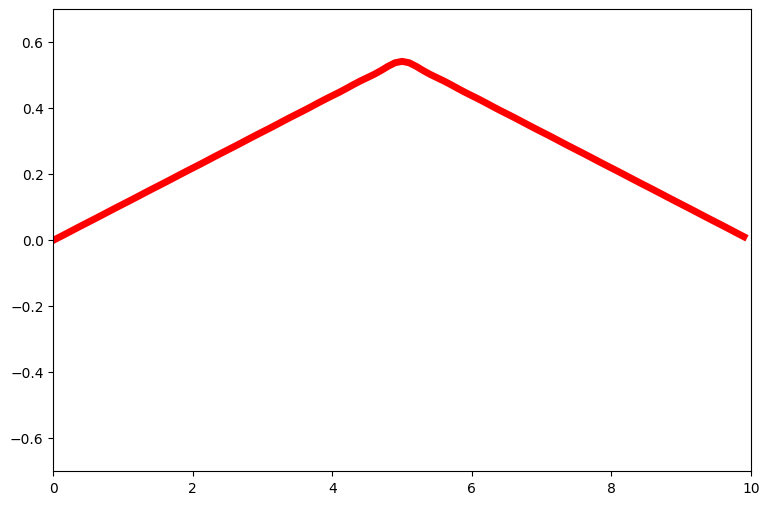

In [ ]:
import matplotlib.animation as animation
# from   matplotlib import rc
from IPython.display import HTML
T = 4*a_l**2/np.pi
fig = plt.figure(figsize=(9,6))              # Setup da figura
ax = plt.axes(xlim=[0,a_l],ylim=[-0.7,0.7])  # Setup dos eixos.
# Agora definimos a linha para o gráfico, line width = 5, color="red".
line, = ax.plot(x_r,np.zeros(len(x_r)),lw=5,color="red")
def animate(t):                              # atualizar a linha para t.
    y_p = [np.real(psi_f(x,t,a_l)) for x in x_r] # Computar os dados.
    line.set_data(x_r,y_p)                   # Definindo os dados na linha
    line.set_color((t/T,1.-t/T,0))     # Animação da cor com base em t.
    return (line,)                             # retorna a linha como tuple (line,)

def init():
    line.set_data([],[])                     # uma linha branca.
    return (line,)

# Em seguida, chamamos a função de animação. Ela faz todo o trabalho, mas
# em um Jupyter notebook, não estará visivelmente em movimento.
#Nós animamos 100 quadros de 0 a T e então repetimos.
ani = animation.FuncAnimation(fig, animate, np.linspace(0.,T,100), init_func=init,
                              interval=100, blit=True)
HTML(ani.to_html5_video()) # Isso significa: incorporar a animação como um vídeo.

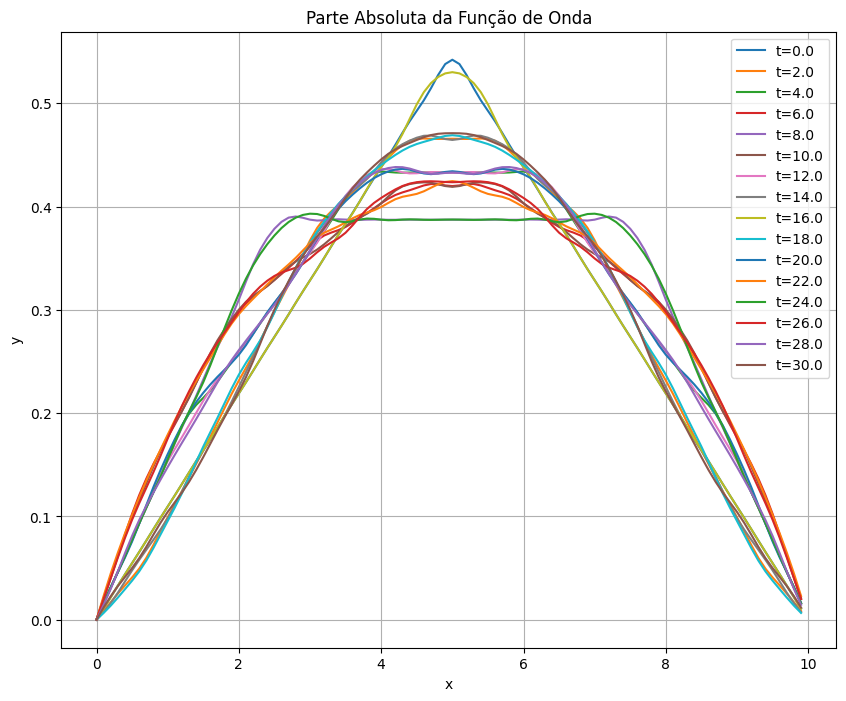

In [ ]:
plt.figure(figsize=(10,8))
x_r = np.arange(0,10,0.1)
for t in np.arange(0.,32.,2.):
    y_p = [np.abs(psi_f(x,t,a_l)) for x in x_r]
    plt.plot(x_r,y_p,label="t={}".format(t))
    plt.legend()
    plt.title("Parte Absoluta da Função de Onda")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True,which='both')
plt.show()

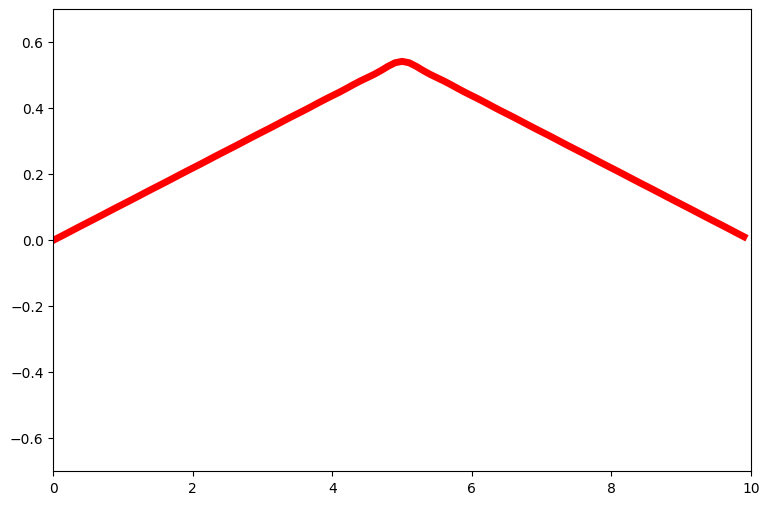

In [ ]:
import matplotlib.animation as animation
# from   matplotlib import rc
from IPython.display import HTML
T = 4*a_l**2/np.pi
fig = plt.figure(figsize=(9,6))              # Setup da figura
ax = plt.axes(xlim=[0,a_l],ylim=[-0.7,0.7])  # Setup dos eixos.
# Agora definimos a linha para o gráfico, line width = 5, color="red".
line, = ax.plot(x_r,np.zeros(len(x_r)),lw=5,color="red")
def animate(t):                              # atualizar a linha para t.
    y_p = [np.abs(psi_f(x,t,a_l)) for x in x_r] # Computar os dados.
    line.set_data(x_r,y_p)                   # Definindo os dados na linha
    line.set_color((t/T,1.-t/T,0))     # Animação da cor com base em t.
    return (line,)                             # retorna a linha como tuple (line,)

def init():
    line.set_data([],[])                     # uma linha branca.
    return (line,)

# Em seguida, chamamos a função de animação. Ela faz todo o trabalho, mas
# em um Jupyter notebook, não estará visivelmente em movimento.
#Nós animamos 100 quadros de 0 a T e então repetimos.
ani = animation.FuncAnimation(fig, animate, np.linspace(0.,T,100), init_func=init,
                              interval=100, blit=True)
HTML(ani.to_html5_video()) # Isso significa: incorporar a animação como um vídeo.